<a href="https://colab.research.google.com/github/WittmannF/course-v4/blob/master/nbs/04_mnist_basics_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Let's first download a utility file for setting up Google Colab
!wget https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py

--2020-03-24 18:24:49--  https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1214 (1.2K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   1.19K  --.-KB/s    in 0s      

2020-03-24 18:24:50 (231 MB/s) - ‘colab_utils.py’ saved [1214/1214]



In [2]:
from colab_utils import setup_fastai_colab
setup_fastai_colab()

    NOTE: For debugging and visualizing stdout, please run:
    from colab_utils import *
    !{REQUIREMENTS_PIP}
    !{GIT_CLONE_REPOSITORY}
    %cd {FASTAI_NB_PATH}

Installing requirements...
Done!
Cloning FastAI Repository...
Done!
Opening folder course-v4/nbs/ with nbs and utils files...
Done!


In [0]:
#hide
from fastai2.vision.all import *
from utils import *

matplotlib.rc('image', cmap='Greys')

# Under the hood: training a digit classifier

## Pixels: the foundations of computer vision

## Sidebar: Tenacity and deep learning

## End sidebar

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [0]:
#hide
Path.BASE_PATH = path

In [6]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [7]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [9]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [10]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First try: pixel similarity

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

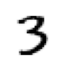

In [14]:
show_image(three_tensors[1]);

In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [16]:
len(stacked_threes.shape)

3

In [17]:
stacked_threes.ndim

3

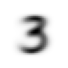

In [18]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

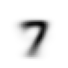

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

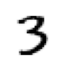

In [20]:
a_3 = stacked_threes[1]
show_image(a_3);

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [23]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy arrays and PyTorch tensors

In [0]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [25]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [27]:
tns[1]

tensor([4, 5, 6])

In [28]:
tns[:,1]

tensor([2, 5])

In [29]:
tns[1,1:3]

tensor([5, 6])

In [30]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [31]:
tns.type()

'torch.LongTensor'

In [32]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing metrics using broadcasting

In [33]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [34]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [35]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1071, 0.1194, 0.1100,  ..., 0.1150, 0.1230, 0.1623]),
 torch.Size([1010]))

In [36]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [37]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [0]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [39]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [40]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [41]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

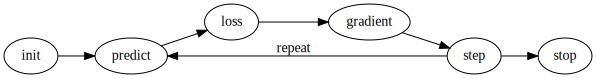

In [42]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [0]:
def f(x): return x**2

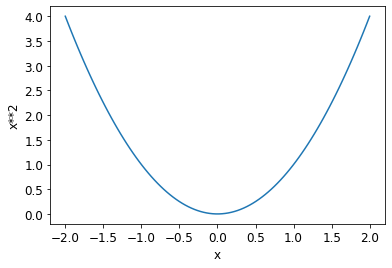

In [44]:
plot_function(f, 'x', 'x**2')

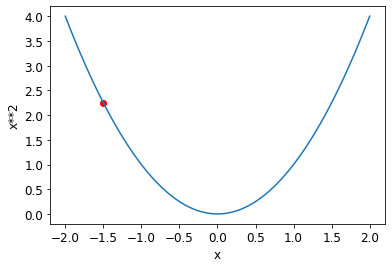

In [45]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### The gradient

In [0]:
xt = tensor(3.).requires_grad_()

In [47]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [0]:
yt.backward()

In [49]:
xt.grad

tensor(6.)

In [50]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [51]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [52]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping with a learning rate

### An end-to-end SGD example

In [53]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

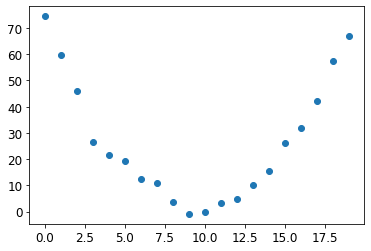

In [54]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [0]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [0]:
def mse(preds, targets): return ((preds-targets)**2).mean()

In [0]:
params = torch.randn(3).requires_grad_()

In [0]:
#hide
orig_params = params.clone()

In [0]:
preds = f(time, params)

In [0]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

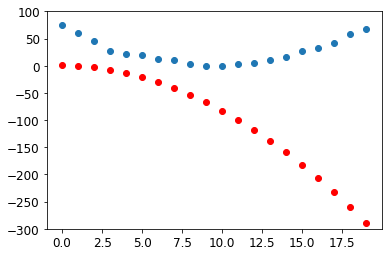

In [61]:
show_preds(preds)

In [62]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

In [63]:
loss.backward()
params.grad

tensor([-53195.8594,  -3419.7146,   -253.8908])

In [64]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [65]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [0]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [67]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5366, grad_fn=<MeanBackward0>)

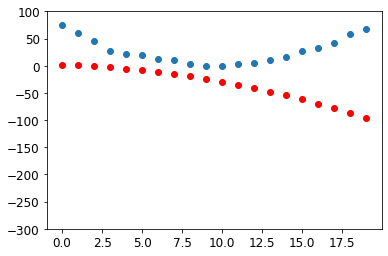

In [68]:
show_preds(preds)

In [0]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [70]:
for i in range(10): apply_step(params)

5435.53662109375
1577.4495849609375
847.3780517578125
709.22265625
683.0757446289062
678.12451171875
677.1839599609375
677.0025024414062
676.96435546875
676.9537353515625


In [0]:
#hide
params = orig_params.detach().requires_grad_()

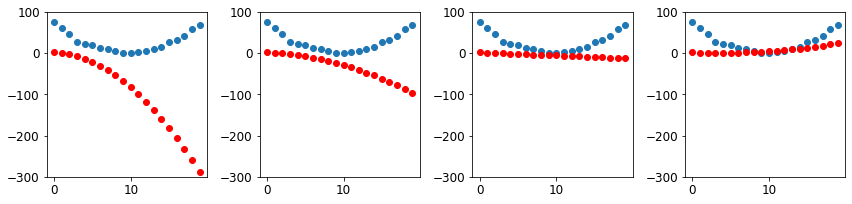

In [72]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Summarizing gradient descent

## MNIST loss function

In [0]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [0]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [75]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [76]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [77]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [0]:
def sigmoid(x): return 1/(1+torch.exp(-x))

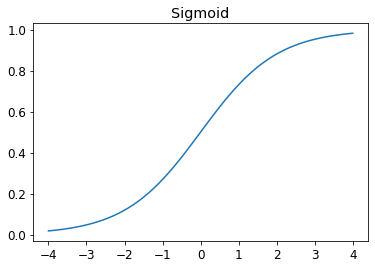

In [79]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [0]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and mini-batches

In [81]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([12, 14,  0, 11, 13]),
 tensor([10,  2,  3,  1,  8]),
 tensor([9, 7, 6, 4, 5])]

In [82]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [83]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([16, 14, 25, 13, 10,  3]), ('q', 'o', 'z', 'n', 'k', 'd')),
 (tensor([ 9, 11, 12, 18,  2, 15]), ('j', 'l', 'm', 's', 'c', 'p')),
 (tensor([ 5, 23,  8, 24, 17,  1]), ('f', 'x', 'i', 'y', 'r', 'b')),
 (tensor([21, 20,  6,  4,  7, 19]), ('v', 'u', 'g', 'e', 'h', 't')),
 (tensor([ 0, 22]), ('a', 'w'))]

## Putting it all together

In [0]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [85]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [86]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [87]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [0]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)

In [0]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [0]:
weights = init_params((28*28,1))

In [0]:
bias = init_params(1)

In [92]:
(train_x[0]*weights.T).sum() + bias

tensor([3.3659], grad_fn=<AddBackward0>)

In [93]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [94]:
def linear1(xb): return xb@weights + bias
preds = linear1(batch)
preds

tensor([[ 3.3659],
        [11.7662],
        [ 8.3530],
        [ 2.4388]], grad_fn=<AddBackward0>)

In [95]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0285, grad_fn=<MeanBackward0>)

In [96]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0044), tensor([-0.0266]))

In [0]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [98]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0088), tensor([-0.0532]))

In [99]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0132), tensor([-0.0797]))

In [0]:
weights.grad.zero_()
bias.grad.zero_();

In [0]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [102]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [0]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [104]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [0]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [106]:
validate_epoch(linear1)

0.5072

In [107]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6434

In [108]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8358 0.9051 0.9295 0.9403 0.9442 0.9515 0.9529 0.9554 0.9564 0.9578 0.9593 0.9598 0.9613 0.9627 0.9642 0.9637 0.9637 0.9647 0.9657 0.9666 

### Creating an optimizer

In [0]:
linear_model = nn.Linear(28*28,1)

In [110]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [0]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [0]:
opt = BasicOptim(linear_model.parameters(), lr)

In [0]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [114]:
validate_epoch(linear_model)

0.4991

In [0]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [116]:
train_model(linear_model, 20)

0.4932 0.8798 0.8154 0.9082 0.9321 0.9453 0.9546 0.9614 0.9653 0.9668 0.9692 0.9712 0.9736 0.9746 0.9761 0.9766 0.9775 0.9775 0.978 0.9785 

In [117]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7686 0.8608 0.9175 0.9365 0.9492 0.957 0.9639 0.9658 0.9688 0.9707 0.9727 0.9746 0.9751 0.9761 0.9766 0.978 0.9785 0.9785 0.9785 

In [0]:
dls = DataLoaders(dl, valid_dl)

In [0]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [120]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637185,0.503677,0.495584,00:00
1,0.624697,0.080337,0.951423,00:00
2,0.224673,0.254758,0.762512,00:00
3,0.096739,0.126054,0.891560,00:00
4,0.049427,0.086741,0.923454,00:00
5,0.031063,0.067563,0.943081,00:00
6,0.023541,0.056106,0.953386,00:00
7,0.020245,0.048657,0.960746,00:00
8,0.018623,0.043533,0.964671,00:00
9,0.017684,0.039822,0.965653,00:00


## Adding a non-linearity

In [0]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [0]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

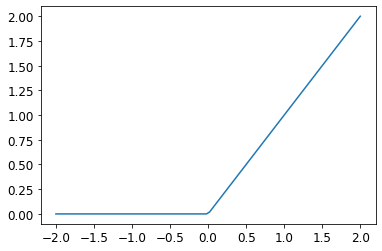

In [123]:
plot_function(F.relu)

In [0]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [0]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [126]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.301377,0.412458,0.504416,00:00
1,0.144385,0.223927,0.808145,00:00
2,0.080781,0.113085,0.915604,00:00
3,0.053451,0.076515,0.941609,00:00
4,0.040678,0.059800,0.956820,00:00
5,0.034108,0.050438,0.964181,00:00
6,0.030310,0.044555,0.964671,00:00
7,0.027830,0.040541,0.968597,00:00
8,0.026038,0.037613,0.969578,00:00
9,0.024646,0.035379,0.971541,00:00


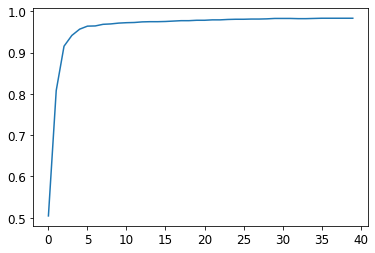

In [127]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [128]:
learn.recorder.values[-1][2]

0.983316957950592

In [129]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.149273,0.020443,0.996565,03:05


## Jargon recap

#### _Choose Your Own Adventure_ reminder

## Questionnaire

1. How is a greyscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank 3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3x3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom right 4 numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini batches?
1. What are the 7 steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between loss and metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudo-code showing the basic steps taken each epoch for SGD.
1. Create a function which, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show python or pseudo-code for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just threes and sevens). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.